In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import folium

# 0. 데이터 전처리
# 여행객 데이터와 방문지 정보를 불러오기
traveler_master = pd.read_csv('/content/traveler_master.csv')
# 여행 스타일 데이터를 정수형으로 변환
traveler_master['TRAVEL_STYL_1'] = traveler_master['TRAVEL_STYL_1'].astype(int)
traveler_master['TRAVEL_STYL_2'] = traveler_master['TRAVEL_STYL_2'].astype(int)
traveler_master['TRAVEL_STYL_3'] = traveler_master['TRAVEL_STYL_3'].astype(int)
traveler_master['TRAVEL_STYL_4'] = traveler_master['TRAVEL_STYL_4'].astype(int)
traveler_master['TRAVEL_STYL_5'] = traveler_master['TRAVEL_STYL_5'].astype(int)


visit_info = pd.read_csv('/content/visit_info.csv', dtype={'X_COORD': str, 'Y_COORD': str})
travel = pd.read_csv('/content/travel.csv')
visit_pre = pd.read_csv('/content/visit_pre.csv')

# 여행 데이터와 방문지 정보를 여행ID(TRAVEL_ID)를 기준으로 합치기
visit_data = pd.merge(travel, visit_info, on = 'TRAVEL_ID')
# 위 데이터를 여행객 마스터와 함치기 (TRAVELER_ID)를 기준으로
visit_final = pd.merge(visit_data, traveler_master, on = 'TRAVELER_ID')

# 목적지가 제주도인 여행객 마스터 데이터와 여행 정보 합치기 -> 제주도 간 사람들만 남게 됨.
travel_pre = pd.merge(travel, traveler_master , on = 'TRAVELER_ID', how = 'inner')



<ipython-input-1-b18439d94795>:17: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  visit_info = pd.read_csv('/content/visit_info.csv', dtype={'X_COORD': str, 'Y_COORD': str})


In [ ]:
travel_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2549 entries, 0 to 2548
Data columns (total 46 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   TRAVEL_ID                  2549 non-null   object 
 1   TRAVEL_NM                  2549 non-null   object 
 2   TRAVELER_ID                2549 non-null   object 
 3   TRAVEL_PURPOSE             2549 non-null   object 
 4   TRAVEL_START_YMD           2549 non-null   object 
 5   TRAVEL_END_YMD             2549 non-null   object 
 6   MVMN_NM                    2549 non-null   int64  
 7   TRAVEL_PERSONA             690 non-null    object 
 8   TRAVEL_MISSION             2549 non-null   object 
 9   TRAVEL_MISSION_CHECK       2549 non-null   object 
 10  RESIDENCE_SGG_CD           2549 non-null   int64  
 11  GENDER                     2549 non-null   object 
 12  AGE_GRP                    2549 non-null   int64  
 13  EDU_NM                     2549 non-null   int64

In [ ]:
visit_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49738 entries, 0 to 49737
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TRAVEL_ID             49738 non-null  object 
 1   TRAVEL_NM             49738 non-null  object 
 2   TRAVELER_ID           49738 non-null  object 
 3   TRAVEL_PURPOSE        49738 non-null  object 
 4   TRAVEL_START_YMD      49738 non-null  object 
 5   TRAVEL_END_YMD        49738 non-null  object 
 6   MVMN_NM               49738 non-null  int64  
 7   TRAVEL_PERSONA        16493 non-null  object 
 8   TRAVEL_MISSION        49738 non-null  object 
 9   TRAVEL_MISSION_CHECK  49738 non-null  object 
 10  VISIT_AREA_ID         49738 non-null  int64  
 11  VISIT_ORDER           49738 non-null  int64  
 12  VISIT_AREA_NM         49738 non-null  object 
 13  VISIT_START_YMD       49738 non-null  object 
 14  VISIT_END_YMD         49738 non-null  object 
 15  ROAD_NM_ADDR       

<ipython-input-4-9af6f03e468a>:5: DtypeWarning: Columns (8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  visit_final = pd.read_csv('/content/visit_info.csv')
<ipython-input-4-9af6f03e468a>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  visit_final_lodging = visit_final_lodging.append(rows_with_home, ignore_index=True)


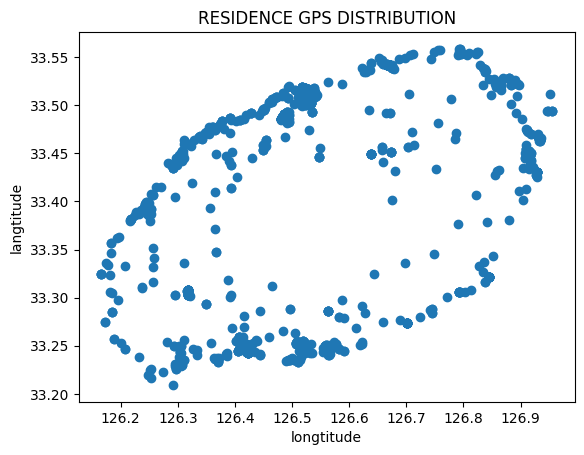

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
visit_final = pd.read_csv('/content/visit_info.csv')
# 'Y_COORD' 열에 오류 데이터가 포함된 행 삭제
visit_final = visit_final[visit_final['Y_COORD'] != 'd34.8410505']
visit_final = visit_final[visit_final['Y_COORD'] != '`']

# 숙소 데이터 추출하기
# 숙소유형코드가 없는 행 삭제
visit_final_lodging = visit_final.dropna(subset=['LODGING_TYPE_CD'])
# 집 추가
rows_with_home = visit_final[visit_final['VISIT_AREA_NM'] == '집']
visit_final_lodging = visit_final_lodging.append(rows_with_home, ignore_index=True)

# 여행 ID가 중복되는 행 제거
visit_final_lodging = visit_final_lodging.drop_duplicates(subset=['TRAVEL_ID'])

# X_COORD와 Y_COORD 열의 '!3' 문자 제거 및 부동 소수점으로 변환
visit_final_lodging['X_COORD'] = visit_final_lodging['X_COORD'].str.replace('!3', '').astype(float)
visit_final_lodging['Y_COORD'] = visit_final_lodging['Y_COORD'].str.replace('!3', '').astype(float)

# 제주도 경계 좌표
jeju_boundary = {'min_lon': 126.08, 'max_lon': 126.96, 'min_lat': 33.06, 'max_lat': 33.70}

# 경계 좌표 내에 있는 데이터만 선택
filtered_data = visit_final_lodging[(visit_final_lodging['X_COORD'] >= jeju_boundary['min_lon']) &
                           (visit_final_lodging['X_COORD'] <= jeju_boundary['max_lon']) &
                           (visit_final_lodging['Y_COORD'] >= jeju_boundary['min_lat']) &
                           (visit_final_lodging['Y_COORD'] <= jeju_boundary['max_lat'])]

# 데이터프레임에서 경도와 위도 추출
longitude = filtered_data['X_COORD']
latitude = filtered_data['Y_COORD']

# 시각화
plt.scatter(longitude, latitude)
plt.xlabel('longtitude')
plt.ylabel('langtitude')
plt.title('RESIDENCE GPS DISTRIBUTION')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Centers:
[[126.86264087  33.45119551]
 [126.53408371  33.50141859]
 [126.52174409  33.25345876]
 [126.29524495  33.35749764]]

Cluster Labels:
[2 1 1 ... 1 1 3]


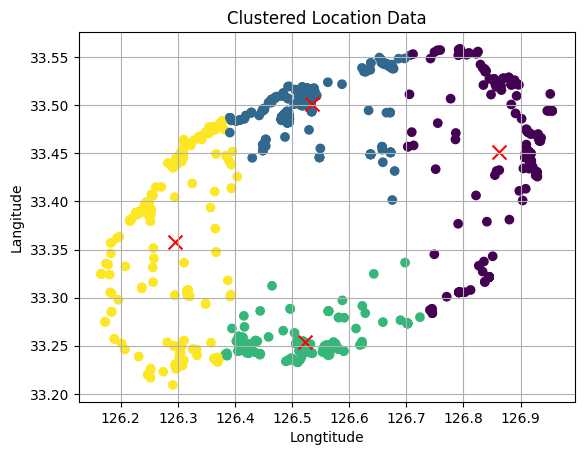

In [ ]:
from sklearn.cluster import KMeans

# 제주도 경계 좌표
jeju_boundary = {'min_lon': 126.09, 'max_lon': 126.96, 'min_lat': 33.06, 'max_lat': 33.70}

# 경계 좌표 내에 있는 데이터만 선택
filtered_data = visit_final_lodging[(visit_final_lodging['X_COORD'] >= jeju_boundary['min_lon']) &
                           (visit_final_lodging['X_COORD'] <= jeju_boundary['max_lon']) &
                           (visit_final_lodging['Y_COORD'] >= jeju_boundary['min_lat']) &
                           (visit_final_lodging['Y_COORD'] <= jeju_boundary['max_lat'])]

locations = np.column_stack((longitude, latitude))

# K-Means 클러스터링
k = 4  # 클러스터 개수
kmeans = KMeans(n_clusters=k)
kmeans.fit(locations)

# 클러스터 중심 위치 확인
cluster_centers = kmeans.cluster_centers_
print("Cluster Centers:")
print(cluster_centers)

# 각 데이터 포인트의 클러스터 할당 확인
labels = kmeans.labels_
print("\nCluster Labels:")
print(labels)

# 클러스터링 결과 시각화
plt.scatter(locations[:, 0], locations[:, 1], c=labels, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', c='red', s=100)
plt.title('Clustered Location Data')
plt.xlabel('Longtitude')
plt.ylabel('Langitude')
plt.grid(True)
plt.show()

In [ ]:
15
import numpy as np


# 숙소의 위치와 클러스터 중심 좌표 입력 받기
accommodation_latitude = float(input("숙소의 위도를 입력하세요: "))
accommodation_longitude = float(input("숙소의 경도를 입력하세요: "))

cluster_centers = np.array([[33.456, 126.123], [33.987, 126.789], [33.654, 126.345], [33.876, 126.567], [33.210, 126.890]])

# 숙소를 포함하는 클러스터의 번호를 찾는 함수 정의
def find_cluster_index(accommodation_longitude, accommodation_latitude, cluster_centers):
    # 숙소의 위치를 2차원 배열로 변환하여 클러스터 중심과의 거리를 계산합니다.
    accommodation_location = np.array([[accommodation_longitude, accommodation_latitude]])
    distances = np.linalg.norm(cluster_centers - accommodation_location, axis=1)

    # 가장 가까운 클러스터의 인덱스를 반환합니다.
    cluster_index = np.argmin(distances)
    return cluster_index + 1  # 클러스터 인덱스는 1부터 시작하므로 1을 더해줍니다.

# 숙소가 속한 클러스터의 인덱스를 찾습니다.
cluster_index = find_cluster_index(accommodation_longitude, accommodation_latitude, cluster_centers)
print(f"숙소가 속한 클러스터 번호: {cluster_index}")






숙소의 위도를 입력하세요: 33.471893367674575
숙소의 경도를 입력하세요: 126.35277744977324
숙소가 속한 클러스터 번호: 1


In [ ]:
### 사용자의 여행 스타일 데이터 입력 받기
user_travel_style = []
style_mapping = {
    1: "(자연 vs 도심)",
    2: "(숙박 vs 당일)",
    3: "(새로운 지역 vs 익숙한 지역)",
    4: "(휴양/휴식 vs 체험활동)",
    5: "(잘 알려지지 않은 방문지 vs 알려진 방문지)",
    6: "(계획에 따른 여행 vs 상황에 따른 여행)",
    7: "(사진촬영 중요하지 않음 vs 사진 촬영 중요)",

}
for i in range(1, 8):
    preference = int(input(f"{style_mapping[i]}에 대한 선호도를 입력하세요 (1부터 7까지의 값): "))
    user_travel_style.append(preference)



(자연 vs 도심)에 대한 선호도를 입력하세요 (1부터 7까지의 값): 7
(숙박 vs 당일)에 대한 선호도를 입력하세요 (1부터 7까지의 값): 1
(새로운 지역 vs 익숙한 지역)에 대한 선호도를 입력하세요 (1부터 7까지의 값): 7
(휴양/휴식 vs 체험활동)에 대한 선호도를 입력하세요 (1부터 7까지의 값): 1
(잘 알려지지 않은 방문지 vs 알려진 방문지)에 대한 선호도를 입력하세요 (1부터 7까지의 값): 2
(계획에 따른 여행 vs 상황에 따른 여행)에 대한 선호도를 입력하세요 (1부터 7까지의 값): 1
(사진촬영 중요하지 않음 vs 사진 촬영 중요)에 대한 선호도를 입력하세요 (1부터 7까지의 값): 1


In [ ]:
###차량 이용 유무에 따른 유사도 짠 코드 ####

import numpy as np

# 목적지가 제주도인 여행객 마스터 데이터와 여행 정보 합치기 -> 제주도 간 사람들만 남게 됨.
travel_pre = pd.merge(travel, traveler_master , on = 'TRAVELER_ID', how = 'inner')

# 클러스터 내 여행객과 사용자 간의 평균 제곱 차이 유사도 계산 함수
def calculate_mse_similarity(user1, user2):
    mse = np.mean((np.array(user1) - np.array(user2)) ** 2)
    return  mse


# MVMN_NM 값에 따라 분류된 여행객의 유사도를 계산하는 함수
def calculate_similarity(users, user_travel_style):
    similarities = []
    for index, row in users.iterrows():
        if row['MVMN_NM'] == 1:  # MVMN_NM 값이 1인 여행객들만 고려
            similarity = calculate_mse_similarity(user_travel_style, row[['TRAVEL_STYL_1', 'TRAVEL_STYL_2', 'TRAVEL_STYL_3', 'TRAVEL_STYL_4', 'TRAVEL_STYL_5', 'TRAVEL_STYL_6', 'TRAVEL_STYL_7']])
            similarities.append((row['TRAVELER_ID'], similarity))
        else:  # MVMN_NM 값이 1이 아닌 여행객들만 고려
            similarity = calculate_mse_similarity(user_travel_style, row[['TRAVEL_STYL_1', 'TRAVEL_STYL_2', 'TRAVEL_STYL_3', 'TRAVEL_STYL_4', 'TRAVEL_STYL_5', 'TRAVEL_STYL_6', 'TRAVEL_STYL_7']])
            similarities.append((row['TRAVELER_ID'], similarity))
    return similarities



# 사용자 입력에 따라 차량 보유 여부 결정
vehicle_usage = input("차량 보유 여부를 입력하세요 (Y/N): ")
if vehicle_usage.upper() == 'Y':
    # MVMN_NM가 1인 여행객들만 고려하여 유사도 계산
    similar_users = calculate_similarity(travel_pre[travel_pre['MVMN_NM'] == 1], user_travel_style)
else:
    # MVMN_NM가 2인 여행객들만 고려하여 유사도 계산
    similar_users = calculate_similarity(travel_pre[travel_pre['MVMN_NM'] != 1], user_travel_style)

# 유사도를 기준으로 상위 10명의 여행객 추출
top_similar_customers = sorted(similar_users, key=lambda x: x[1])[:10]

# 상위 10명의 여행객 출력
print("내 인근 숙소를 잡은 여행객 중 비슷한 여행 스타일을 가진 상위 10명의 여행객:")
for index, (traveler_id, similarity) in enumerate(top_similar_customers, start=1):
    print(f"번호: {index}, 여행객 ID: {traveler_id}, 유사도: {1 / ( 1 + similarity)}")

차량 보유 여부를 입력하세요 (Y/N): Y
내 인근 숙소를 잡은 여행객 중 비슷한 여행 스타일을 가진 상위 10명의 여행객:
번호: 1, 여행객 ID: d005338, 유사도: 0.3181818181818182
번호: 2, 여행객 ID: c000002, 유사도: 0.2692307692307692
번호: 3, 여행객 ID: d006146, 유사도: 0.25925925925925924
번호: 4, 여행객 ID: d003234, 유사도: 0.25
번호: 5, 여행객 ID: d002972, 유사도: 0.24137931034482762
번호: 6, 여행객 ID: a000553, 유사도: 0.23333333333333334
번호: 7, 여행객 ID: a003558, 유사도: 0.22580645161290322
번호: 8, 여행객 ID: b009691, 유사도: 0.22580645161290322
번호: 9, 여행객 ID: d000447, 유사도: 0.21875
번호: 10, 여행객 ID: d003471, 유사도: 0.21212121212121213



위도 경도 값 입력
예시

In [ ]:
# 상위 10명의 여행객 ID 가져오기
top_travelers_ids = [traveler_id for traveler_id, _ in top_similar_customers[:5]]

# 상위 10명 중 상위 5명의 여행객의 어트랙션 방문 기록 가져오기
visit_pre_top_5 = visit_pre[visit_pre['TRAVELER_ID'].isin(top_travelers_ids)]

# TOU 값에 해당하는 어트랙션만 선택
visit_pre_top_5 = visit_pre_top_5[visit_pre_top_5['VISIT_AREA_TYPE_CD'] == 'TOU']

# 어트랙션의 만족도 계산하여 새로운 열 추가
visit_pre_top_5['total_satisfaction'] = visit_pre_top_5['DGSTFN'] + visit_pre_top_5['REVISIT_INTENTION'] + visit_pre_top_5['RCMDTN_INTENTION']

# 만족도를 기준으로 내림차순 정렬
visit_pre_top_5_sorted = visit_pre_top_5.sort_values(by=['TRAVELER_ID', 'total_satisfaction'], ascending=[True, False])

# 상위 5명의 만족도가 가장 높은 어트랙션 출력
print("상위 5명의 만족도가 가장 높은 어트랙션:")
for i, traveler_id in enumerate(top_travelers_ids, start=1):
    top_attractions = visit_pre_top_5_sorted[visit_pre_top_5_sorted['TRAVELER_ID'] == traveler_id].head(4)
    print(f"여행객 {i}: {traveler_id}")
    if top_attractions.empty:
        print("    - 추천된 어트랙션 개수가 없습니다") #특정 여행객에 대해 추천된 어트랙션이 전혀 없거나 적은 경우
    else:
        top_attractions.reset_index(drop=True, inplace=True)
        for j, row in top_attractions.iterrows():
            attraction_order = f"추천된 어트랙션 {j+1}"
            print(f"    - {attraction_order}: {row['VISIT_AREA_NM_NP']} / 만족도: {row['total_satisfaction']}")
            print(f"      - DGSTFN: {row['DGSTFN']}, REVISIT_INTENTION: {row['REVISIT_INTENTION']}, RCMDTN_INTENTION: {row['RCMDTN_INTENTION']}")
        # 만약 추천된 어트랙션이 4개 미만이면 나머지 어트랙션은 값이 없는 것으로 처리
        if len(top_attractions) < 4:
            for k in range(len(top_attractions), 4):
                print(f"    - 추천된 어트랙션 {k+1}: 추천된 어트랙션이 적습니다") # 만약 어떤 여행객에게는 추천된 어트랙션은 있지만 그 개수가 4개보다 적을 경우


상위 5명의 만족도가 가장 높은 어트랙션:
여행객 1: d005338
    - 추천된 어트랙션 1: 닭머르해안길 1코스 / 만족도: 12
      - DGSTFN: 4, REVISIT_INTENTION: 4, RCMDTN_INTENTION: 4
    - 추천된 어트랙션 2: 파파빌레 / 만족도: 7
      - DGSTFN: 3, REVISIT_INTENTION: 2, RCMDTN_INTENTION: 2
    - 추천된 어트랙션 3: 추천된 어트랙션이 적습니다
    - 추천된 어트랙션 4: 추천된 어트랙션이 적습니다
여행객 2: c000002
    - 추천된 어트랙션 개수가 없습니다
여행객 3: d006146
    - 추천된 어트랙션 개수가 없습니다
여행객 4: d003234
    - 추천된 어트랙션 1: 황우지해안 / 만족도: 15
      - DGSTFN: 5, REVISIT_INTENTION: 5, RCMDTN_INTENTION: 5
    - 추천된 어트랙션 2: 어음리억새군락지 / 만족도: 15
      - DGSTFN: 5, REVISIT_INTENTION: 5, RCMDTN_INTENTION: 5
    - 추천된 어트랙션 3: 새별오름 / 만족도: 15
      - DGSTFN: 5, REVISIT_INTENTION: 5, RCMDTN_INTENTION: 5
    - 추천된 어트랙션 4: 군산오름 전망대 / 만족도: 15
      - DGSTFN: 5, REVISIT_INTENTION: 5, RCMDTN_INTENTION: 5
여행객 5: d002972
    - 추천된 어트랙션 1: 협재해수욕장 / 만족도: 15
      - DGSTFN: 5, REVISIT_INTENTION: 5, RCMDTN_INTENTION: 5
    - 추천된 어트랙션 2: 제주현대미술관 / 만족도: 14
      - DGSTFN: 5, REVISIT_INTENTION: 4, RCMDTN_INTENTION: 5
    - 추천된 어트랙션 3

In [ ]:
visit_pre_top_5_sorted

,TRAVELER_ID,TRAVEL_ID,VISIT_ORDER,VISIT_AREA_NM_NP,VISIT_AREA_NM,VISIT_AREA_TYPE_CD,X_COORD,Y_COORD,DGSTFN,REVISIT_INTENTION,RCMDTN_INTENTION,total_satisfaction
12185,d002972,d_d002972,12,협재해수욕장,협재해수욕장,TOU,126.239158,33.393866,5,5,5,15
12181,d002972,d_d002972,6,제주현대미술관,제주현대미술관,TOU,126.309591,33.462459,5,4,5,14
12182,d002972,d_d002972,7,금오름,금오름,TOU,126.310468,33.459323,4,4,4,12
12190,d002972,d_d002972,23,성이시돌목장,성이시돌목장,TOU,126.327321,33.347770,4,3,3,10
12187,d002972,d_d002972,18,팜파스 갈대정원,팜파스 갈대정원,TOU,126.514630,33.254348,4,2,3,9
12802,d003234,d_d003234,13,황우지해안,황우지해안,TOU,126.550528,33.241467,5,5,5,15
12806,d003234,d_d003234,19,어음리억새군락지,어음리억새군락지,TOU,126.368172,33.377644,5,5,5,15
12808,d003234,d_d003234,22,새별오름,새별오름,TOU,126.357731,33.366278,5,5,5,15
12811,d003234,d_d003234,36,군산오름 전망대,군산오름 전망대,TOU,126.369735,33.253157,5,5,5,15
12813,d003234,d_d003234,38,스팅그레이,스팅그레이,TOU,126.247343,33.304083,5,5,5,15


In [ ]:
# 해당 어트랙션 위치를 지도에 표시
import folium

# 지도 초기 설정
m = folium.Map(location=[33.37, 126.5], zoom_start=11)

# 상위 5명의 여행객의 색상 설정
colors = ['red', 'blue', 'green', 'orange', 'purple']

# 각 여행객의 어트랙션 위치를 지도에 추가
for i, traveler_id in enumerate(top_travelers_ids, start=1):
    color = colors[i % len(colors)]  # 여행객 별로 색상 선택
    top_attractions = visit_pre_top_5_sorted[visit_pre_top_5_sorted['TRAVELER_ID'] == traveler_id].head(5)
    for j, (index, row) in enumerate(top_attractions.iterrows(), start=1):
        lat, lon = row['Y_COORD'], row['X_COORD']
        attraction_name = row['VISIT_AREA_NM_NP']
        tooltip = f'여행객: {i}, 어트랙션: {attraction_name}'  # 여행객 번호와 어트랙션 정보를 마커 위에 표시
        folium.Marker(location=[lat, lon], icon=folium.Icon(color=color), tooltip=tooltip).add_to(m)  # 위도, 경도 순서로 수정

# 지도를 HTML 파일로 저장
m.save('attraction_map.html')


In [ ]:
# 20개의 어트랙션을 모두 포함하는 데이터프레임 생성
attractions_info = []

# 각 여행객의 상위 어트랙션 정보를 가져와서 attractions_info에 추가
for traveler_id in top_travelers_ids:
    top_attractions = visit_pre_top_5_sorted[visit_pre_top_5_sorted['TRAVELER_ID'] == traveler_id].head(4)
    for _, row in top_attractions.iterrows():
        attraction_info = {
            '어트랙션명': row['VISIT_AREA_NM_NP'],
            '위도': row['Y_COORD'],
            '경도': row['X_COORD'],
            '만족도': row['total_satisfaction']
        }
        attractions_info.append(attraction_info)

# attractions_info를 기반으로 데이터프레임 생성
attractions_df = pd.DataFrame(attractions_info)
attractions_df = attractions_df.drop_duplicates(subset=['어트랙션명', '위도', '경도'], keep='first')

In [ ]:
import numpy as np

#만족도 기준으로 상위 4개 추출(만족도가 15인 것이 4개 이상이면 만족도가 15인 것들만 남기기)
# 만족도가 높은 순으로 데이터프레임을 정렬
attractions_df_sorted = attractions_df.sort_values(by='만족도', ascending=False)

In [ ]:
attractions_df_sorted

,어트랙션명,위도,경도,만족도
2,황우지해안,33.241467,126.550528,15
3,어음리억새군락지,33.377644,126.368172,15
4,새별오름,33.366278,126.357731,15
5,군산오름 전망대,33.253157,126.369735,15
6,협재해수욕장,33.393866,126.239158,15
7,제주현대미술관,33.462459,126.309591,14
0,닭머르해안길 1코스,33.537167,126.616124,12
8,금오름,33.459323,126.310468,12
9,성이시돌목장,33.347770,126.327321,10
1,파파빌레,33.460443,126.660850,7


In [ ]:
# 만족도가 15인 것이 4개 이상인 경우 해당 만족도가 15인 것만 남기고 나머지는 삭제
if len(attractions_df_sorted[attractions_df_sorted['만족도'] == 15]) >= 4:
    attractions_df_sorted = attractions_df_sorted[attractions_df_sorted['만족도'] == 15]
# 만족도가 15인 것이 4개 이하인 경우 상위 4개만 남기고 나머지는 삭제
elif len(attractions_df_sorted[attractions_df_sorted['만족도'] == 15]) < 4:
    attractions_df_sorted = attractions_df_sorted.head(4)

In [ ]:
attractions_df_sorted

,어트랙션명,위도,경도,만족도
2,황우지해안,33.241467,126.550528,15
3,어음리억새군락지,33.377644,126.368172,15
4,새별오름,33.366278,126.357731,15
5,군산오름 전망대,33.253157,126.369735,15
6,협재해수욕장,33.393866,126.239158,15


In [ ]:
#위치와 이름
names = np.array(attractions_df_sorted['어트랙션명']) #호텔 이름을 맨 앞에
longitude = np.array(attractions_df_sorted['경도']) #호텔 젤 앞에
latitude = np.array(attractions_df_sorted['위도']) #호텔 젤 앞에
lodging = np.array(['숙소', accommodation_longitude, accommodation_latitude])

In [ ]:
#숙소/어트랙션 데이터 하나로 합치기
atr_data = np.array([[i,j,k] for i,j,k in zip(names, longitude, latitude)])
atr_data = np.vstack((lodging, atr_data))
atr_data

array([['숙소', '126.35277744977324', '33.471893367674575'],
       ['황우지해안', '126.5505278', '33.24146718'],
       ['어음리억새군락지', '126.368172', '33.37764356'],
       ['새별오름', '126.3577307', '33.36627759'],
       ['군산오름 전망대', '126.3697348', '33.25315727'],
       ['협재해수욕장', '126.2391575', '33.39386608']], dtype='<U32')

In [ ]:
#시작점 숙소로 설정 후 가장 가까운 어트랙션 찾는 과정을 반복
atr_series = []
next_index = 0
start = atr_data[next_index]
while len(atr_data) > 1:
    # 전체 데이터에서 시작점 빼기
    atr_data = np.delete(atr_data, next_index, axis=0)
    # 나머지 모든 점과의 거리 계산하기
    distance = []
    for p in atr_data:
        p = p[1:].astype(np.float32)
        starts = start[1:].astype(np.float32)
        distance.append(np.sqrt(np.sum((p - starts) ** 2)))
    # 가장 가까운 점 찾기
    next_index = np.where(distance == np.min(distance))[0][0]
    start = atr_data[next_index]
    atr_series.append(start)
atr_series = np.array(atr_series)

In [ ]:
# 상위 4개만 추출
atr_series_sorted = atr_series[:4]
print(atr_series_sorted)

[['어음리억새군락지' '126.368172' '33.37764356']
 ['새별오름' '126.3577307' '33.36627759']
 ['군산오름 전망대' '126.3697348' '33.25315727']
 ['황우지해안' '126.5505278' '33.24146718']]


In [ ]:
import folium


# 지도 초기 설정
m = folium.Map(location=[33.37, 126.5], zoom_start=11)

# 숙소 위치 마커 추가
folium.Marker(location=[accommodation_latitude, accommodation_longitude], icon=folium.Icon(color='black'), tooltip='숙소').add_to(m)

# 어트랙션 위치 마커 추가
for attraction_info in atr_series_sorted:
    attraction_name = attraction_info[0]
    latitude = float(attraction_info[2])
    longitude = float(attraction_info[1])
    folium.Marker(location=[latitude, longitude], tooltip=attraction_name).add_to(m)

# 지도를 HTML 파일로 저장

In [ ]:
# 근처 레스토랑과 카페 추천
rest_names = visit_pre.loc[visit_pre['VISIT_AREA_TYPE_CD'] == 'RES', 'VISIT_AREA_NM_NP'].values
rest_longitude = visit_pre.loc[visit_pre['VISIT_AREA_TYPE_CD'] == 'RES', 'X_COORD'].values
rest_latitude = visit_pre.loc[visit_pre['VISIT_AREA_TYPE_CD'] == 'RES', 'Y_COORD'].values

# 레스토랑 하나의 데이터로 합치기
rest_data = np.array([[a,b,c] for a,b,c in zip(rest_names, rest_longitude, rest_latitude)])

# 중복된 레스토랑 이름 처리
unique_restaurants = {}
for name, longitude, latitude in rest_data:
    if name not in unique_restaurants:
        unique_restaurants[name] = [longitude, latitude]

rest_data= [(name, longitude, latitude) for name, (longitude, latitude) in unique_restaurants.items()]

# 1번 어트랙션과 3번 어트랙션에 대해 가장 가까운 카페와 음식점 추천(첫번째가 점심, 두번째가 저녁)
rest_recommend = []
for i in [0, 2]:
    st_point = atr_series[i][1:].astype(np.float32)
    rest_distances = []

    # 어트랙션과 레스토랑 사이의 거리 계산 후 최소값 찾기
    for name, longitude, latitude in rest_data:
        p = np.array([longitude, latitude], dtype=np.float32)
        rest_distances.append(np.sqrt(np.sum((st_point - p) ** 2)))

    # 가장 가까운 레스토랑 두 개 추출
    min_distance_indices = np.argsort(rest_distances)[:2]
    closest_restaurants = [(rest_data[idx][0], rest_data[idx][1], rest_data[idx][2]) for idx in min_distance_indices]

    # 추천된 레스토랑 정보를 리스트에 추가
    for j, restaurant in enumerate(closest_restaurants, start=1):
        rest_recommend.append((f"어트랙션 {i+1}에서 추천된 레스토랑 {j}", restaurant))

# 이미 추천된 어트랙션 필터링
attractions_recommended = set()
for label, restaurant in rest_recommend:
    attraction_number = int(label.split()[1].replace('에서', ''))
    attractions_recommended.add(attraction_number)

# 결과 출력
print("추천된 레스토랑 정보:")
for i, (label, restaurant) in enumerate(rest_recommend, start=1):
    print(f"{label}: {restaurant[0]}, 위도: {restaurant[2]}, 경도: {restaurant[1]}")


추천된 레스토랑 정보:
어트랙션 1에서 추천된 레스토랑 1: 브로콜리지, 위도: 33.39056128, 경도: 126.365972
어트랙션 1에서 추천된 레스토랑 2: 새빌, 위도: 33.36431115, 경도: 126.3629702
어트랙션 3에서 추천된 레스토랑 1: 제주237, 위도: 33.26228771, 경도: 126.3691541
어트랙션 3에서 추천된 레스토랑 2: 춘심이네 본점, 위도: 33.26448563, 경도: 126.3705335


레전드네 아침미소목장 TOU,RES 동시 만족하네;;;

In [ ]:
import folium

# 지도 초기 설정
m = folium.Map(location=[33.37, 126.5], zoom_start=11)

# 숙소 위치 마커 추가 (원 모양)
folium.CircleMarker(location=[accommodation_latitude, accommodation_longitude], radius=5, color='black', fill=True, fill_color='black', tooltip='숙소').add_to(m)

# 추천된 어트랙션 위치 마커 추가 (삼각형 모양)
for i, attraction_info in enumerate(atr_series_sorted[:-1], start=1):
    attraction_name = attraction_info[0]
    next_attraction_info = atr_series_sorted[i]
    next_attraction_name = next_attraction_info[0]
    start_latitude = float(attraction_info[2])
    start_longitude = float(attraction_info[1])
    end_latitude = float(next_attraction_info[2])
    end_longitude = float(next_attraction_info[1])
    folium.RegularPolygonMarker(location=[start_latitude, start_longitude], number_of_sides=3, radius=8, color='blue', fill=True, fill_color='blue', tooltip=f"어트랙션 {i}: {attraction_name}").add_to(m)
    folium.RegularPolygonMarker(location=[end_latitude, end_longitude], number_of_sides=3, radius=8, color='blue', fill=True, fill_color='blue', tooltip=f"어트랙션 {i+1}: {next_attraction_name}").add_to(m)
    folium.PolyLine([(start_latitude, start_longitude), (end_latitude, end_longitude)], color="blue").add_to(m)

# 마지막 어트랙션 마커 추가 (삼각형 모양)
last_attraction_name = atr_series_sorted[-1][0]
last_attraction_latitude = float(atr_series_sorted[-1][2])
last_attraction_longitude = float(atr_series_sorted[-1][1])
folium.RegularPolygonMarker(location=[last_attraction_latitude, last_attraction_longitude], number_of_sides=3, radius=8, color='blue', fill=True, fill_color='blue', tooltip=f"어트랙션 {len(atr_series_sorted)}: {last_attraction_name}").add_to(m)

# 추천된 레스토랑 위치 마커 추가 (원 모양)
for i, (label, restaurant) in enumerate(rest_recommend, start=1):
    restaurant_name = restaurant[0]
    latitude = float(restaurant[2])
    longitude = float(restaurant[1])
    folium.CircleMarker(location=[latitude, longitude], radius=5, color='#FF8C00', fill=True, fill_color='green', tooltip=f"{label}: {restaurant_name}").add_to(m)

# 지도를 HTML 파일로 저장
m.save('final_map.html')
